In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from itertools import product, repeat, permutations, combinations_with_replacement, chain
from os import listdir
import sys, os
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize

sys.path.append('../models/')
os.chdir('../models/')

from contours import find_contours, draw_bbox_contours

%matplotlib inline

In [2]:
def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.xticks([]), plt.yticks([])

In [3]:
files = listdir('../data')
filename = '../data/' + files[np.random.randint(0, len(files))]

In [4]:
original = cv.cvtColor(cv.imread(filename), cv.COLOR_RGB2GRAY)

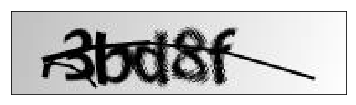

In [5]:
show_image(original)

In [6]:
contours = find_contours(original.astype(np.float32) / 255)

In [7]:
len(contours)

2

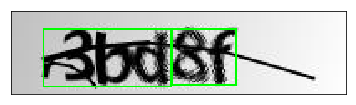

In [8]:
show_image(draw_bbox_contours(cv.cvtColor(original, cv.COLOR_GRAY2RGB), contours))

Remove contours which we predict that dont have any character at all

In [9]:
contours = [contour for contour in contours if contour.num_chars > 0]

In [10]:
len(contours)

2

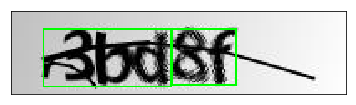

In [11]:
show_image(draw_bbox_contours(cv.cvtColor(original, cv.COLOR_GRAY2RGB), contours))

Sort contours by its horizontal position (from left to right)

In [12]:
contours = sorted(contours, key=lambda contour: contour.bbox.left)

Now we create a 2D matrix where the element at index i,j will be the probability of the frame i to contain j characters inside

In [13]:
P = np.array([contour.num_chars_proba for contour in contours])

In [14]:
P.argmax(axis=1)

array([3, 2])

In [15]:
np.round(P, 2)

array([[0.01, 0.  , 0.01, 0.65, 0.33, 0.  ],
       [0.  , 0.08, 0.9 , 0.01, 0.  , 0.  ]])

If n0, n1, ..., nk are the number of predicted characters inside each frame, we find the best configuration so that n0 + n1 + ... + nk = 5 (total number of characters in the image)
and ensure that P[0, n[0]] * P[1, n[1]] * ... * P[k, n[k]] is maximized

In [16]:
configs = filter(lambda x: np.sum(x) == 5,combinations_with_replacement(range(0, 5+1), len(contours)))

configs = chain.from_iterable(map(lambda config: permutations(config, len(contours)), configs))

configs = np.array(list(configs), dtype=np.uint16)

In [17]:
configs[0:10:2]

array([[0, 5],
       [1, 4],
       [2, 3]], dtype=uint16)

In [36]:
scores = np.zeros([len(configs)]).astype(np.float32)

for k in range(0, len(configs)):
    scores[k] = np.prod([P[i, configs[k][i]] for i in range(0, len(contours))])

In [99]:
print(P)
P[np.arange(0, len(contours)), np.array(configs[0])]

[[0.00520065 0.00288023 0.00900545 0.65234697 0.32657412 0.00399259]
 [0.00313292 0.07855554 0.90393726 0.00976067 0.00254079 0.00207282]]


array([0.00520065, 0.00207282])

In [19]:
np.max(scores)

0.58968073

In [20]:
best_config = configs[np.argmax(scores)]

This is our best configuration

In [21]:
best_config

array([3, 2], dtype=uint16)

Now we know where the characters are in the image. We need to split the frame where there are multiple chars

In [22]:
frame = contours[[k for k in range(0, len(contours)) if best_config[k] > 1][0]]
mask, pixels = frame.bbox_mask, frame.extract_bbox_pixels(original)

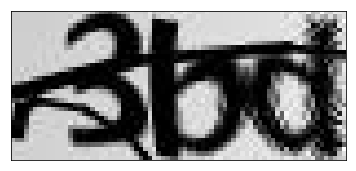

In [23]:
show_image(pixels)

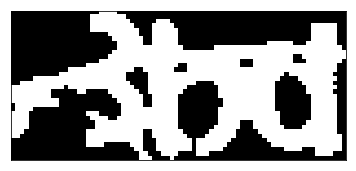

In [24]:
show_image(mask)

In [25]:
f = (mask > 0).mean(axis=0)
a, b = f.min(), f.max()
f = (f - a) / (b - a)
n, k = len(f), frame.num_chars
x = np.arange(0, n)
s0 = np.linspace(0, n, k+1)[1:-1]

In [26]:
s0

array([25.33333333, 50.66666667])

In [27]:
bounds = np.transpose(np.stack([np.maximum(s0 - 8, 15), np.minimum(s0 + 8, n - 15)], axis=0))

In [28]:
alpha = 0
W = lambda s: (np.concatenate((s, [n])) - np.concatenate(([0.0], s))) / n
F1 = lambda s: alpha * W(s).var()

dFW = lambda s: 2 * alpha * (W(s) - W(s).mean()) / k
dF1 = lambda s: np.cumsum(dFW(s))[:-1]

In [29]:
beta = 1
y_spl = UnivariateSpline(x, f, s=0,k=4)
y_spl_df = y_spl.derivative(n=1)


F2 = lambda s: beta * np.sum(y_spl(s))
dF2 = lambda s: beta * y_spl_df(s) / (k - 1)

In [30]:
F = lambda s: F1(s) + F2(s)
dF = lambda s: dF1(s) + dF2(s)

In [31]:
jac = lambda s, *args: dF(s)
result = minimize(F, s0, jac=jac, method='SLSQP', bounds=bounds)
s = np.round(result.x)

In [32]:
F(s0), F(s)

(1.5308178460551827, 0.8275862068965518)

In [33]:
result

     fun: 0.795826340269371
     jac: array([-1.48483153e-06,  1.83106455e-05])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([30.23547918, 53.66650674])

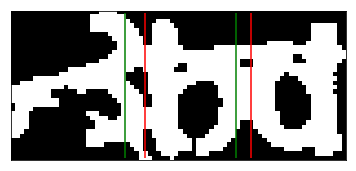

In [34]:
show_image(mask)
plt.vlines(s0, ymin=0, ymax=mask.shape[0]-1, color='green')
plt.vlines(s, ymin=0, ymax=mask.shape[0]-1, color='red')

Final result

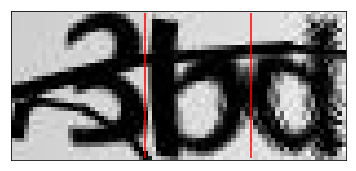

In [35]:
show_image(frame.extract_bbox_pixels(original))
plt.vlines(s, ymin=0, ymax=mask.shape[0]-1, color='red')